## Package Import

In [50]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2, l1
from tensorflow.keras.models import load_model
from joblib import dump, load
import matplotlib.pyplot as plt

## Read File

In [2]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [col.strip() for col in data.columns]

## Create isolation forest model to remove outliers
[API Link to IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [3]:
old_data_length = len(data)
IF_model = IsolationForest(contamination=0.1) # Remove 10% data
outliers = IF_model.fit_predict(data.drop(columns=['url', 'timedelta', 'shares'])) # Delete columns than don't need in IF and train IF model
data['outliers'] = outliers

# Remove outliers
data_outliers = data[data['outliers'] == -1]
new_data = data[data['outliers'] != -1].drop(columns = ['outliers'])

new_data_len = len(new_data)

print(f"There are total {old_data_length - new_data_len} rows been removied.")

There are total 3965 rows been removied.


## Creat a function to classify an article to different categories
* Great Article: Shares >= 90%
* Good Article: 70% <= Shares < 90%
* Normal Article: 30% <= Shares < 70%
* Bad article: Shares < 30%

In [4]:
def article_classifier(shares, top_percent):
    if shares >= top_percent[0.9]:
        return 'Great'
    elif shares >= top_percent[0.7]:
        return 'Good'
    elif shares >= top_percent[0.3]:
        return 'Normal'
    else:
        return 'Bad'


## Data Classifier

In [5]:
top_percent = new_data['shares'].quantile([0.3, 0.7, 0.9])

quality = []
for index, row in new_data.iterrows():
    quality.append(article_classifier(row['shares'], top_percent))

new_data['quality'] = quality

## Split dataset into x and y and one-hot encode quality column

In [6]:
x = new_data.drop(columns=['quality', 'url', 'timedelta', 'shares'], axis=1)
y = new_data['quality']
le = LabelEncoder()
y = le.fit_transform(y)
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(x)
xTrain, xTest, yTrain, yTest = train_test_split(scaled_X, y, test_size=0.2, random_state=10)
scale_xTrain = pd.DataFrame(xTrain)
scale_xTest = pd.DataFrame(xTest)

## NN1

In [ ]:
from keras.callbacks import EarlyStopping

nn1 = Sequential([
    Dense(256, activation='relu', input_dim=scale_xTrain.shape[1]),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l1(0.001)),
    Dense(4, activation='softmax'),
])

nn1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = nn1.fit(scale_xTrain, yTrain, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
nn1.save('nn1.h5')

Epoch 1/100
803/803 [==============================] - 3s 3ms/step - loss: 1.3495 - accuracy: 0.4335 - val_loss: 1.2363 - val_accuracy: 0.4497
Epoch 2/100
803/803 [==============================] - 3s 3ms/step - loss: 1.2253 - accuracy: 0.4425 - val_loss: 1.2310 - val_accuracy: 0.4252
Epoch 3/100
803/803 [==============================] - 3s 3ms/step - loss: 1.2109 - accuracy: 0.4464 - val_loss: 1.2151 - val_accuracy: 0.4438
Epoch 4/100
803/803 [==============================] - 3s 3ms/step - loss: 1.2036 - accuracy: 0.4504 - val_loss: 1.2054 - val_accuracy: 0.4441
Epoch 5/100
803/803 [==============================] - 3s 3ms/step - loss: 1.1981 - accuracy: 0.4513 - val_loss: 1.1967 - val_accuracy: 0.4473
Epoch 6/100
803/803 [==============================] - 3s 3ms/step - loss: 1.1929 - accuracy: 0.4521 - val_loss: 1.1957 - val_accuracy: 0.4469
Epoch 7/100
803/803 [==============================] - 3s 3ms/step - loss: 1.1902 - accuracy: 0.4539 - val_loss: 1.1949 - val_accuracy: 0.4406

## NN1 analysis

892/892 [==============================] - 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      8339
           1       0.83      0.76      0.80      5656
           2       0.72      0.80      0.76      2904
           3       0.82      0.85      0.84     11644

    accuracy                           0.82     28543
   macro avg       0.80      0.81      0.80     28543
weighted avg       0.82      0.82      0.82     28543


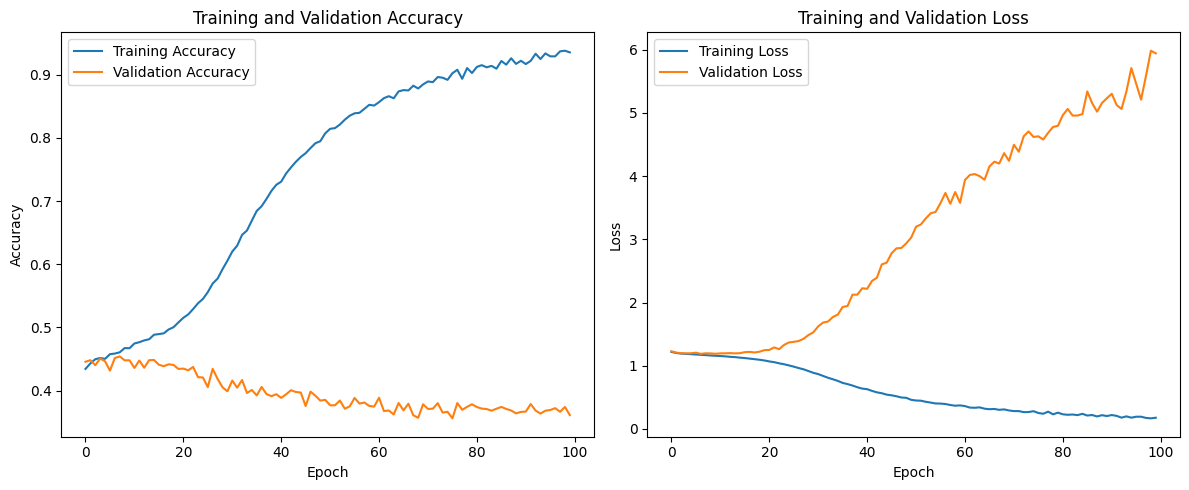

In [42]:
y_pred = nn1.predict(scale_xTrain)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(yTrain, y_pred_classes))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## NN2

In [24]:
nn2 = Sequential([
    Dense(512, activation='tanh', input_dim=scale_xTrain.shape[1]),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(4, activation='softmax'),
])
nn2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = nn2.fit(scale_xTrain, yTrain, epochs=100, batch_size=32)
nn2.save('nn2.h5')

Epoch 1/100
892/892 [==============================] - 3s 3ms/step - loss: 1.2294 - accuracy: 0.4272
Epoch 2/100
892/892 [==============================] - 3s 3ms/step - loss: 1.2104 - accuracy: 0.4351
Epoch 3/100
892/892 [==============================] - 3s 3ms/step - loss: 1.2031 - accuracy: 0.4429
Epoch 4/100
892/892 [==============================] - 3s 3ms/step - loss: 1.2012 - accuracy: 0.4433
Epoch 5/100
892/892 [==============================] - 3s 3ms/step - loss: 1.1983 - accuracy: 0.4432
Epoch 6/100
892/892 [==============================] - 3s 3ms/step - loss: 1.1966 - accuracy: 0.4453
Epoch 7/100
892/892 [==============================] - 3s 3ms/step - loss: 1.1953 - accuracy: 0.4449
Epoch 8/100
892/892 [==============================] - 3s 3ms/step - loss: 1.1934 - accuracy: 0.4474
Epoch 9/100
892/892 [==============================] - 3s 3ms/step - loss: 1.1938 - accuracy: 0.4471
Epoch 10/100
892/892 [==============================] - 3s 3ms/step - loss: 1.1899 - accura

## NN2 Analysis

In [25]:
y_pred = nn2.predict(scale_xTrain)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(yTrain, y_pred_classes))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

892/892 [==============================] - 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      8339
           1       0.80      0.78      0.79      5656
           2       0.85      0.75      0.79      2904
           3       0.84      0.84      0.84     11644

    accuracy                           0.83     28543
   macro avg       0.83      0.81      0.82     28543
weighted avg       0.83      0.83      0.83     28543


## Random Forest

In [32]:
RF_model = RandomForestClassifier(n_estimators=200)
RF_model.fit(scale_xTrain, yTrain)
dump(RF_model, 'RF.joblib')

['RF.joblib']

## RF Analysis

In [33]:
y_pred = RF_model.predict(scale_xTest)
print("Classification Report:")
print(classification_report(yTrain, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      8339
           1       0.80      0.78      0.79      5656
           2       0.85      0.75      0.79      2904
           3       0.84      0.84      0.84     11644

    accuracy                           0.83     28543
   macro avg       0.83      0.81      0.82     28543
weighted avg       0.83      0.83      0.83     28543
